- Multistep LSTM (link sent in slack)
- GRU model (Gated Recurrent Unit)
- Attention Mechanism
- Vanilla LSTM

#### Multistep LSTM 

/home/maatrika/Desktop/NasaL2/nasa2/lib/python3.10/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([566, 10, 1])) that is different to the input size (torch.Size([566, 10, 10])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [10/100], Loss: 0.0610
Epoch [20/100], Loss: 0.0350
Epoch [30/100], Loss: 0.0235
Epoch [40/100], Loss: 0.0212
Epoch [50/100], Loss: 0.0206
Epoch [60/100], Loss: 0.0204
Epoch [70/100], Loss: 0.0204
Epoch [80/100], Loss: 0.0203
Epoch [90/100], Loss: 0.0203
Epoch [100/100], Loss: 0.0203
Root Mean Square Error (RMSE): 1.480981716340274


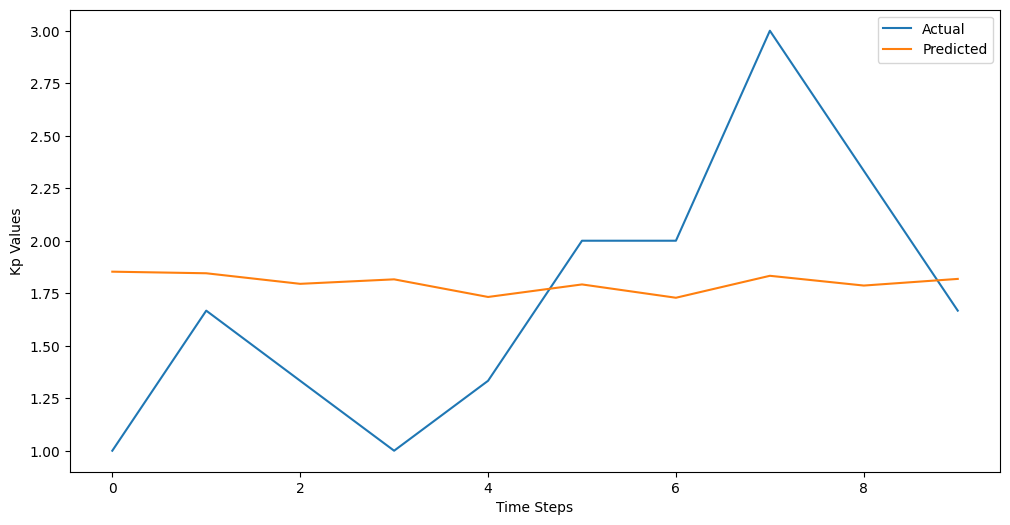

In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# Load your preprocessed dataset
df = pd.read_csv('fianl_cleaned.csv')

# Select the target variable 'Kp' as a numpy array
kp_values = df['Kp'].values

# Normalize the data
scaler = MinMaxScaler()
kp_values = scaler.fit_transform(kp_values.reshape(-1, 1))

# Define hyperparameters
n_steps_in = 30  # Number of time steps to look back (input sequence length)
n_steps_out = 10  # Number of time steps to predict into the future (output sequence length)
n_features = 1  # Number of features (in this case, 1 for 'Kp')
n_epochs = 100  # Number of training epochs
batch_size = 32  # Batch size

# Prepare the dataset for training
X, y = [], []
for i in range(len(kp_values) - n_steps_in - n_steps_out):
    X.append(kp_values[i:i + n_steps_in])
    y.append(kp_values[i + n_steps_in:i + n_steps_in + n_steps_out])

X = np.array(X)
y = np.array(y)

# Split the dataset into training and testing sets
split_ratio = 0.8
split_index = int(split_ratio * len(X))

X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

# Define the LSTM model using PyTorch
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -n_steps_out:, :])
        return out

# Create the model
model = LSTMModel(input_size=n_features, hidden_size=50, output_size=n_steps_out)

# Define loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Convert numpy arrays to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)

# Training loop
for epoch in range(n_epochs):
    outputs = model(X_train)
    optimizer.zero_grad()
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{n_epochs}], Loss: {loss.item():.4f}')

# Evaluate the model
model.eval()
with torch.no_grad():
    y_pred = model(X_test)
y_pred = y_pred.numpy()

# Inverse transform the predictions and actual values to their original scale
y_pred = scaler.inverse_transform(y_pred.reshape(-1, n_steps_out)).reshape(-1, n_steps_out)
y_test = scaler.inverse_transform(y_test.reshape(-1, n_steps_out)).reshape(-1, n_steps_out)

# Reshape y_pred to match the shape of y_test
y_pred = y_pred[:y_test.shape[0], :]

# Now, y_test and y_pred should have the same shape
assert y_test.shape == y_pred.shape

# Calculate RMSE for evaluation
rmse = np.sqrt(np.mean((y_test - y_pred) ** 2))
print(f"Root Mean Square Error (RMSE): {rmse}")

# Visualize the predictions
plt.figure(figsize=(12, 6))
plt.plot(y_test[-1], label='Actual')
plt.plot(y_pred[-1], label='Predicted')
plt.xlabel('Time Steps')
plt.ylabel('Kp Values')
plt.legend()
plt.show()



/home/maatrika/Desktop/NasaL2/nasa2/lib/python3.10/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([566, 10, 1])) that is different to the input size (torch.Size([566, 10, 10])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [10/100], Loss: 0.0304
Epoch [20/100], Loss: 0.0213
Epoch [30/100], Loss: 0.0208
Epoch [40/100], Loss: 0.0198
Epoch [50/100], Loss: 0.0193
Epoch [60/100], Loss: 0.0190
Epoch [70/100], Loss: 0.0187
Epoch [80/100], Loss: 0.0185
Epoch [90/100], Loss: 0.0182
Epoch [100/100], Loss: 0.0176
Mean Squared Error (MSE): 2.1109284533592247
Root Mean Square Error (RMSE): 1.4529034563105785


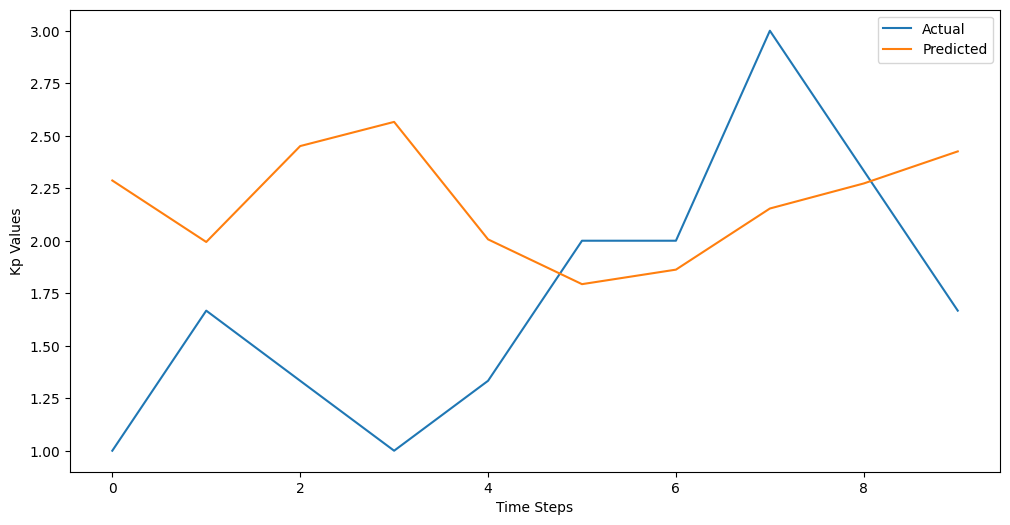

In [14]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# Load your preprocessed dataset
df = pd.read_csv('fianl_cleaned.csv')

# Select the target variable 'Kp' as a numpy array
kp_values = df['Kp'].values

# Normalize the data
scaler = MinMaxScaler()
kp_values = scaler.fit_transform(kp_values.reshape(-1, 1))

# Define hyperparameters
n_steps_in = 30  # Number of time steps to look back (input sequence length)
n_steps_out = 10  # Number of time steps to predict into the future (output sequence length)
n_features = 13  # Number of features (including 'Kp' and additional features)
n_epochs = 100  # Number of training epochs
batch_size = 32  # Batch size

# Prepare the dataset for training with additional features
X, y = [], []
for i in range(len(df) - n_steps_in - n_steps_out):
    X.append(df[['Kp', 'Bt-med', 'Bt-min', 'Bt-max', 'Bx-max', 'By-min', 'Bz-med', 'Bz-min', 'Theta-med', 'Theta-min', 'Dens-med', 'Dens-max', 'Speed-max']][i:i + n_steps_in].values)
    y.append(kp_values[i + n_steps_in:i + n_steps_in + n_steps_out])

X = np.array(X)
y = np.array(y)

# Split the dataset into training and testing sets
split_ratio = 0.8
split_index = int(split_ratio * len(X))

X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

# Define the LSTM model using PyTorch to handle multiple features
class MultivariateLSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MultivariateLSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -n_steps_out:, :])
        return out

# Create the model
model = MultivariateLSTMModel(input_size=n_features, hidden_size=200, output_size=n_steps_out)

# Define loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Convert numpy arrays to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)

# Training loop
for epoch in range(n_epochs):
    outputs = model(X_train)
    optimizer.zero_grad()
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{n_epochs}], Loss: {loss.item():.4f}')

# Evaluate the model
model.eval()
with torch.no_grad():
    y_pred = model(X_test)
y_pred = y_pred.numpy()

# Inverse transform the predictions and actual values to their original scale
y_pred = scaler.inverse_transform(y_pred.reshape(-1, n_steps_out)).reshape(-1, n_steps_out)
y_test = scaler.inverse_transform(y_test.reshape(-1, n_steps_out)).reshape(-1, n_steps_out)

# Reshape y_pred to match the shape of y_test
y_pred = y_pred[:y_test.shape[0], :]

# Now, y_test and y_pred should have the same shape
assert y_test.shape == y_pred.shape

mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error (MSE): {mse}")

# Calculate RMSE for evaluation
rmse = np.sqrt(np.mean((y_test - y_pred) ** 2))
print(f"Root Mean Square Error (RMSE): {rmse}")

# Visualize the predictions
plt.figure(figsize=(12, 6))
plt.plot(y_test[-1], label='Actual')
plt.plot(y_pred[-1], label='Predicted')
plt.xlabel('Time Steps')
plt.ylabel('Kp Values')
plt.legend()
plt.show()


#### GRU model (Gated Recurrent Unit)

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Load your preprocessed dataset (replace 'your_dataset.csv' with your actual dataset file)
df = pd.read_csv('fianl_cleaned.csv')

# Select the target variable 'Kp' and other relevant features as numpy arrays
selected_features = ['Bt-med', 'Bt-min', 'Bt-max', 'Bx-max', 'By-min', 'Bz-med', 'Bz-min',
                     'Theta-med', 'Theta-min', 'Dens-med', 'Dens-max', 'Speed-max', 'Kp']

data = df[selected_features].values

# Normalize the data
scaler = MinMaxScaler()
data = scaler.fit_transform(data)

# Define hyperparameters
n_steps_in = 30  # Number of time steps to look back (input sequence length)
n_steps_out = 10  # Number of time steps to predict into the future (output sequence length)
n_features = len(selected_features) - 1  # Number of input features (excluding 'Kp')
n_epochs = 100  # Number of training epochs
batch_size = 32  # Batch size

# Prepare the dataset for training
X, y = [], []
for i in range(len(data) - n_steps_in - n_steps_out):
    X.append(data[i:i + n_steps_in, :-1])  # Exclude 'Kp' from input features
    y.append(data[i + n_steps_in:i + n_steps_in + n_steps_out, -1])  # 'Kp' as the target

X = np.array(X)
y = np.array(y)

# Split the dataset into training and testing sets
split_ratio = 0.8
split_index = int(split_ratio * len(X))

X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

# Define the GRU model using PyTorch
class GRUModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(GRUModel, self).__init__()
        self.hidden_size = hidden_size
        self.gru = nn.GRU(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.gru(x)
        out = self.fc(out[:, -n_steps_out:, :])
        return out

# Create the model
model = GRUModel(input_size=n_features, hidden_size=50, output_size=n_steps_out)

# Define loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Convert numpy arrays to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)

# Training loop
for epoch in range(n_epochs):
    outputs = model(X_train)
    optimizer.zero_grad()

    # Reshape y_train to match the shape of outputs
    y_train_reshaped = y_train[:, :, np.newaxis]

    loss = criterion(outputs, y_train_reshaped)
    loss.backward()
    optimizer.step()
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{n_epochs}], Loss: {loss.item():.4f}')

# Evaluate the model
model.eval()
with torch.no_grad():
    y_pred = model(X_test)
y_pred = y_pred.numpy()

# Concatenate the 'Kp' values from X_test and y_pred for inverse transformation
y_pred = scaler.inverse_transform(np.hstack((X_test[:, :, -1], y_pred)))
y_test = scaler.inverse_transform(np.hstack((X_test[:, :, -1], y_test)))


# Inverse transform each feature separately
y_pred = scaler.inverse_transform(np.hstack((X_test[:, :, -1], y_pred)))
y_test = scaler.inverse_transform(np.hstack((X_test[:, :, -1], y_test)))

# Now, y_test and y_pred should have the same shape
assert y_test.shape == y_pred.shape

# Calculate MSE for evaluation
mse = mean_squared_error(y_test[:, -1], y_pred[:, -1])
print(f"Mean Squared Error (MSE): {mse}")

# Calculate R-squared (R2) score for evaluation
r2 = r2_score(y_test[:, -1], y_pred[:, -1])
print(f"R-squared (R2) Score: {r2}")

# Visualize the predictions
plt.figure(figsize=(12, 6))
plt.plot(y_test[:, -1], label='Actual')
plt.plot(y_pred[:, -1], label='Predicted')
plt.xlabel('Time Steps')
plt.ylabel('Kp Values')
plt.legend()
plt.show()


#Difficulty with dimentions of the data

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from torch.nn import TransformerEncoderLayer


df = pd.read_csv('fianl_cleaned.csv')

selected_features = ['Bt-med', 'Bt-min', 'Bt-max', 'Bx-max', 'By-min', 'Bz-med', 'Bz-min',
                     'Theta-med', 'Theta-min', 'Dens-med', 'Dens-max', 'Speed-max', 'Kp']

data = df[selected_features].values

#normalize the data
scaler = MinMaxScaler()
data = scaler.fit_transform(data)

n_steps_in = 30  #time steps to look back (input sequence length)
n_steps_out = 10  #time steps to predict into the future (output sequence length)
n_features = len(selected_features) - 1  
n_epochs = 100 
batch_size = 32  

X, y = [], []
for i in range(len(data) - n_steps_in - n_steps_out):
    X.append(data[i:i + n_steps_in, :-1])  
    y.append(data[i + n_steps_in:i + n_steps_in + n_steps_out, -1])  

X = np.array(X)
y = np.array(y)


split_ratio = 0.8
split_index = int(split_ratio * len(X))

X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

#transformer-based model with an attention mechanism
class TransformerModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, n_layers, nhead, dropout):
        super(TransformerModel, self).__init__()

        self.model_type = 'Transformer'
        self.src_mask = None
        self.pos_encoder = PositionalEncoding(input_dim, dropout)
        encoder_layers = TransformerEncoderLayer(input_dim, nhead, hidden_dim, dropout)
        self.transformer_encoder = TransformerEncoder(encoder_layers, n_layers)
        self.encoder = nn.Linear(input_dim, hidden_dim)
        self.decoder = nn.Linear(hidden_dim, output_dim)

    def forward(self, src):
        src = self.encoder(src)
        src = self.pos_encoder(src)
        output = self.transformer_encoder(src)
        output = self.decoder(output)
        return output

# Define a custom PositionalEncoding module
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float32).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)
    
    
# Define the dimensions of the model
input_dim = n_features
hidden_dim = 512  
num_heads = 8     

#ensure that embed_dim is divisible by num_heads
assert hidden_dim % num_heads == 0, "hidden_dim must be divisible by num_heads"

model = TransformerModel(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=n_steps_out, n_layers=6, nhead=num_heads, dropout=0.1)

#define loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Convert numpy arrays to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)

#training loop
for epoch in range(n_epochs):
    outputs = model(X_train)
    optimizer.zero_grad()
    
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()
    
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{n_epochs}], Loss: {loss.item():.4f}')


model.eval()
with torch.no_grad():
    y_pred = model(X_test).numpy()

#inverse transform the predictions and actual values to their original scale
y_pred = scaler.inverse_transform(y_pred)
y_test = scaler.inverse_transform(y_test)

mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error (MSE): {mse}")

r2 = r2_score(y_test, y_pred)
print(f"R-squared (R2) Score: {r2}")

plt.figure(figsize=(12, 6))
plt.plot(y_test[:, -1], label='Actual')
plt.plot(y_pred[:, -1], label='Predicted')
plt.xlabel('Time Steps')
plt.ylabel('Kp Values')
plt.legend()
plt.show()


#AssertionError: embed_dim must be divisible by num_heads --> ddin't work even after manually setting it

#### Multivariate LSTM

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

df = pd.read_csv('fianl_cleaned.csv')

selected_features = ['Bt-med', 'Bt-min', 'Bt-max', 'Bx-max', 'By-min', 'Bz-med', 'Bz-min', 'Theta-med', 'Theta-min', 
                     'Dens-med', 'Dens-max', 'Speed-max', 'Kp']

data = df[selected_features].values

n_steps_in, n_steps_out = 30, 10
n_features = len(selected_features) - 1
n_epochs = 100
batch_size = 32

X, y = [], []
for i in range(len(data) - n_steps_in - n_steps_out):
    X.append(data[i:i + n_steps_in, :-1])
    y.append(data[i + n_steps_in:i + n_steps_in + n_steps_out, -1])

X = np.array(X)
y = np.array(y)
split = 0.8
split_index = int(split * len(X))
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

# Flatten the input data to 2D for scaling
X_train_flattened = X_train.reshape((X_train.shape[0]*X_train.shape[1], X_train.shape[2]))
X_test_flattened = X_test.reshape((X_test.shape[0]*X_test.shape[1], X_test.shape[2]))

scaler = MinMaxScaler()
scaler.fit(X_train_flattened)

#transform and inverse the flatten operation
X_train = scaler.transform(X_train_flattened)
X_train = X_train.reshape(-1, n_steps_in, n_features)

X_test = scaler.transform(X_test_flattened)
X_test = X_test.reshape(-1, n_steps_in, n_features)

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -n_steps_out:, :])
        return out

model = LSTMModel(input_size=n_features, hidden_size=50, output_size=n_steps_out)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

#convert numpy arrays to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)

#training loop
for epoch in range(n_epochs):
    outputs = model(X_train)
    optimizer.zero_grad()

    #reshape y_train to match the shape of outputs
    y_train_reshaped = y_train.view(-1, 1, n_steps_out)

    loss = criterion(outputs, y_train_reshaped)
    loss.backward()
    optimizer.step()
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{n_epochs}], Loss: {loss.item():.4f}')

model.eval()
with torch.no_grad():
    y_pred = model(X_test)
y_pred_numpy = y_pred.numpy()

#flatten the prediction data to 2D for inverse transformation
y_pred_numpy_flattened = y_pred_numpy.reshape(-1, n_steps_out)

y_pred_inv = []

#inverse transform each feature separately
for i in range(n_steps_out):
    y_pred_i = scaler.inverse_transform(y_pred_numpy_flattened[:, i].reshape(-1, 1))
    y_pred_inv.append(y_pred_i)

#concatenate the inverse transformed features along the last axis to get the final shape
y_pred_inv = np.concatenate(y_pred_inv, axis=-1)

#reshape our transformed prediction back to the original 3D format 
y_pred_inv = y_pred_inv.reshape(y_pred_numpy.shape)



mse = mean_squared_error(y_test, y_pred_inv)
print(f"Mean Squared Error (MSE): {mse}")

r2 = r2_score(y_test, y_pred_inv)
print(f"R-squared (R2) Score: {r2}")

plt.figure(figsize=(12, 6))
plt.plot(y_test[:, -1], label='Actual')
plt.plot(y_pred_inv[:, -1], label='Predicted')
plt.xlabel('Time Steps')
plt.ylabel('Kp Values')
plt.legend()
plt.show()

#issues with dimensions

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

df = pd.read_csv('fianl_cleaned.csv')

selected_features = ['Bt-med', 'Bt-min', 'Bt-max', 'Bx-max', 'By-min', 'Bz-med', 'Bz-min', 'Theta-med', 'Theta-min', 
                     'Dens-med', 'Dens-max', 'Speed-max', 'Kp']

data = df[selected_features].values

n_steps_in, n_steps_out = 30, 10
n_features = len(selected_features) - 1
n_epochs = 100
batch_size = 32

X, y = [], []
for i in range(len(data) - n_steps_in - n_steps_out):
    X.append(data[i:i + n_steps_in, :-1])
    y.append(data[i + n_steps_in:i + n_steps_in + n_steps_out, -1])

X = np.array(X)
y = np.array(y)
split = 0.8
split_index = int(split * len(X))
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

#flatten the input data to 2D for scaling
X_train_flattened = X_train.reshape((X_train.shape[0]*X_train.shape[1], X_train.shape[2]))
X_test_flattened = X_test.reshape((X_test.shape[0]*X_test.shape[1], X_test.shape[2]))

scaler = MinMaxScaler()
scaler.fit(X_train_flattened)

#transform and inverse the flatten operation
X_train = scaler.transform(X_train_flattened)
X_train = X_train.reshape(-1, n_steps_in, n_features)

X_test = scaler.transform(X_test_flattened)
X_test = X_test.reshape(-1, n_steps_in, n_features)

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -n_steps_out:, :])
        return out

model = LSTMModel(input_size=n_features, hidden_size=50, output_size=n_steps_out)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

#convert numpy arrays to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)

#training loop
for epoch in range(n_epochs):
    outputs = model(X_train)
    optimizer.zero_grad()

    #reshape y_train to match the shape of outputs
    y_train_reshaped = y_train.view(-1, 1, n_steps_out)

    loss = criterion(outputs, y_train_reshaped)
    loss.backward()
    optimizer.step()
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{n_epochs}], Loss: {loss.item():.4f}')

model.eval()
with torch.no_grad():
    y_pred = model(X_test)
y_pred_numpy = y_pred.numpy()

#flatten the prediction data to 3D for inverse transformation
y_pred_numpy_flattened = y_pred_numpy.reshape(-1, n_steps_out, n_features)

#create a list to store the inverse transformed predictions for each feature separately
y_pred_inv = []

#inverse transform each feature separately
for i in range(n_features):
    y_pred_i = scaler.inverse_transform(y_pred_numpy_flattened[:, :, i])
    y_pred_inv.append(y_pred_i)

#concatenate the inverse transformed features along the last axis to get the final shape
y_pred_inv = np.stack(y_pred_inv, axis=-1)

#now reshape our transformed prediction back to the original 3D format 
y_pred_inv = y_pred_inv.reshape(y_pred_numpy_flattened.shape)

mse = mean_squared_error(y_test, y_pred_inv)
print(f"Mean Squared Error (MSE): {mse}")

r2 = r2_score(y_test, y_pred_inv)
print(f"R-squared (R2) Score: {r2}")

plt.figure(figsize=(12, 6))
plt.plot(y_test[:, -1], label='Actual')
plt.plot(y_pred_inv[:, -1], label='Predicted')
plt.xlabel('Time Steps')
plt.ylabel('Kp Values')
plt.legend()
plt.show()


#numpy -> tensor errors

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

df = pd.read_csv('fianl_cleaned.csv')

selected_features = ['Bt-med', 'Bt-min', 'Bt-max', 'Bx-max', 'By-min', 'Bz-med', 'Bz-min', 'Theta-med', 'Theta-min', 
                     'Dens-med', 'Dens-max', 'Speed-max']

data = df[selected_features].values

n_steps_in, n_steps_out = 30, 10
n_features = len(selected_features)
n_epochs = 100
batch_size = 32

X, y = [], []
for i in range(len(data) - n_steps_in - n_steps_out):
    X.append(data[i:i + n_steps_in, :])
    y.append(data[i + n_steps_in:i + n_steps_in + n_steps_out, -1])

X = np.array(X)
y = np.array(y)
split = 0.8
split_index = int(split * len(X))
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

#normalize the input data
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train.reshape(-1, n_features))
X_test_scaled = scaler.transform(X_test.reshape(-1, n_features))

#reshape data to match LSTM input shape
X_train_scaled = X_train_scaled.reshape(-1, n_steps_in, n_features)
X_test_scaled = X_test_scaled.reshape(-1, n_steps_in, n_features)
y_train_scaled = y_train.reshape(-1, n_steps_out)
y_test_scaled = y_test.reshape(-1, n_steps_out)


model = tf.keras.Sequential([
    tf.keras.layers.LSTM(50, activation='tanh', return_sequences=True, input_shape=(n_steps_in, n_features)),
    tf.keras.layers.LSTM(50, activation='tanh', return_sequences=True),
    tf.keras.layers.Dense(n_steps_out)
])



model.compile(optimizer='adam', loss='mse')

#training the model
model.fit(X_train_scaled, y_train_scaled, epochs=n_epochs, batch_size=batch_size, verbose=1)

#make predictions on the test data
y_pred_scaled = model.predict(X_test_scaled)

#reshape predicted data to match the original shape
y_pred = y_pred_scaled.reshape(-1, n_steps_out)

#inverse transform the predictions
y_pred_inv = scaler.inverse_transform(np.hstack((X_test_scaled.reshape(-1, n_features), y_pred_scaled)))

#extract the predicted Kp values
y_pred_kp = y_pred_inv[:, -1]

#extract the actual Kp values from the test set
y_test_kp = y_test_scaled[:, -1]


mse = mean_squared_error(y_test_kp, y_pred_kp)
print(f"Mean Squared Error (MSE): {mse}")

r2 = r2_score(y_test_kp, y_pred_kp)
print(f"R-squared (R2) Score: {r2}")

plt.figure(figsize=(12, 6))
plt.plot(y_test_kp, label='Actual Kp')
plt.plot(y_pred_kp, label='Predicted Kp')
plt.xlabel('Time Steps')
plt.ylabel('Kp Values')
plt.legend()
plt.show()


# inference training issues